In [149]:
import ddsp
import IPython.display as ipd
import soundfile as sf
# from ddsp.colab.colab_utils import play, specplot, DEFAULT_SAMPLE_RATE
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import tensorflow as tf
import io
from scipy.io import wavfile

In [116]:
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size
sample_rate = 16000
harmonic = ddsp.synths.Harmonic(n_samples=n_samples, sample_rate=sample_rate)


In [150]:
# Aplitudes
amps = np.linspace(1.0, -3.0, n_frames)
amps = amps[np.newaxis,:, np.newaxis]
# Harmonic distribution
n_harmonics = 30
harmonic_distribution = (np.linspace(-2.0, 2.9, n_frames)[:, np.newaxis] + np.linspace(3.0, -3.0, n_harmonics)[np.newaxis, :])

print("AMPS:", amps.shape)

harmonic_distribution = harmonic_distribution[np.newaxis, :, :]
print(f"Reshaped Harmonic: {harmonic_distribution.shape}")
f_0_hz = 440.0 * np.ones([1, n_frames,1], dtype=np.float32) # Frequency in Hz
print(f"{f_0_hz.shape}")
time= np.linspace(0, n_samples/sample_rate, n_frames)
print(time.shape)

AMPS: (1, 1000, 1)
Reshaped Harmonic: (1, 1000, 30)
(1, 1000, 1)


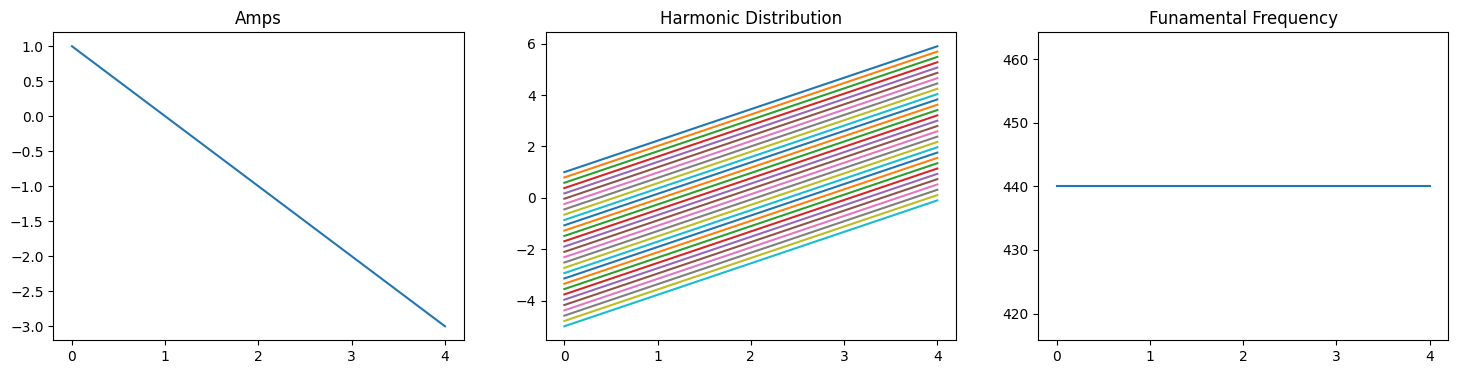

In [119]:
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.plot(time, amps[0, :, 0])
plt.xticks(np.arange(0, 5).tolist())
plt.title("Amps")

plt.subplot(132)
plt.plot(time, harmonic_distribution[0, :, :])
plt.xticks(np.arange(0, 5).tolist())
plt.title("Harmonic Distribution")

plt.subplot(133)
plt.plot(time, f_0_hz[0, :, 0])
plt.xticks(np.arange(0, 5).tolist())
_ = plt.title("Funamental Frequency")

In [120]:
controls = harmonic.get_controls(amps, harmonic_distribution, f_0_hz)
print(controls.keys())

dict_keys(['amplitudes', 'harmonic_distribution', 'f0_hz'])


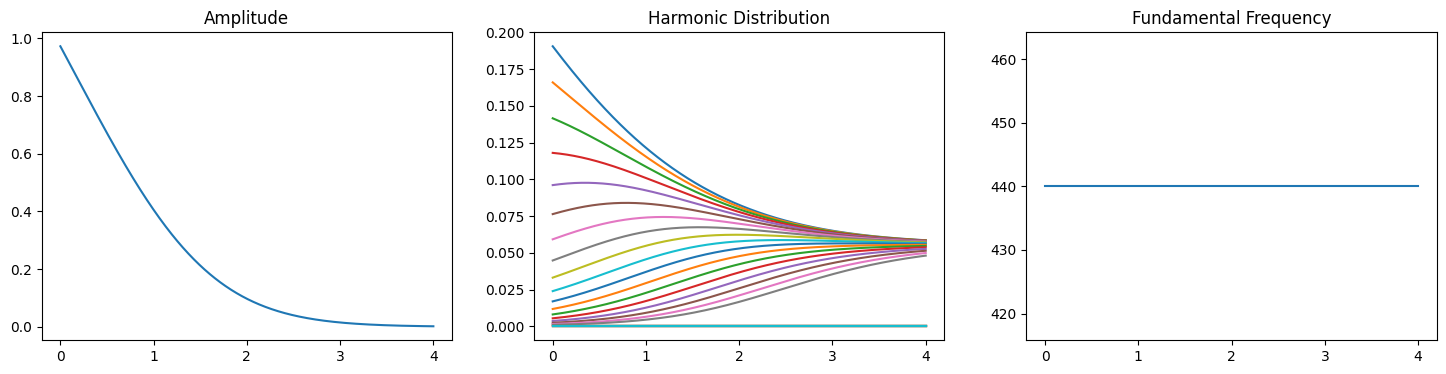

In [121]:
# Now let's see what they look like...
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, controls['amplitudes'][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(132)
plt.plot(time, controls['harmonic_distribution'][0, :, :])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(133)
plt.plot(time, controls['f0_hz'][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title('Fundamental Frequency')


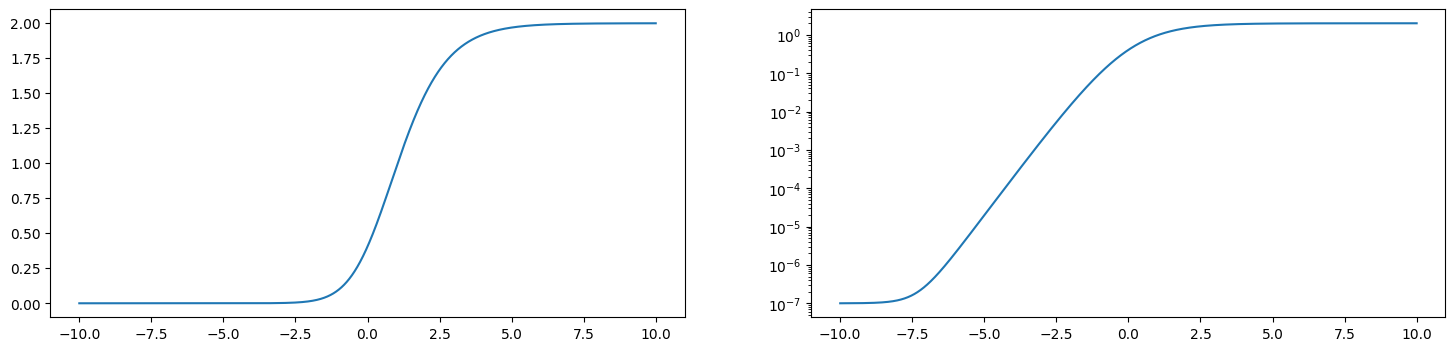

In [122]:
x = tf.linspace(-10.0, 10.0, 10000)
y = ddsp.core.exp_sigmoid(x)
plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(x,y)
plt.subplot(122)
_ = plt.semilogy(x,y)

In [151]:
audio = harmonic.get_signal(**controls)
print(audio.shape)
if len(audio.shape) == 2:
    array_of_floats = audio[0]

normalizer = float(np.iinfo(np.int16).max)
array_of_ints = np.array(np.asarray(array_of_floats) * normalizer)
print(array_of_ints.dtype)

with open("./data/test_whistle.wav", 'rb') as wvf:
    hi, rate = sf.read(wvf)
    time = np.linspace(0, len(hi) / rate, len(hi))
# ipd.Audio(hi, rate=rate)


(1, 64000)
float32


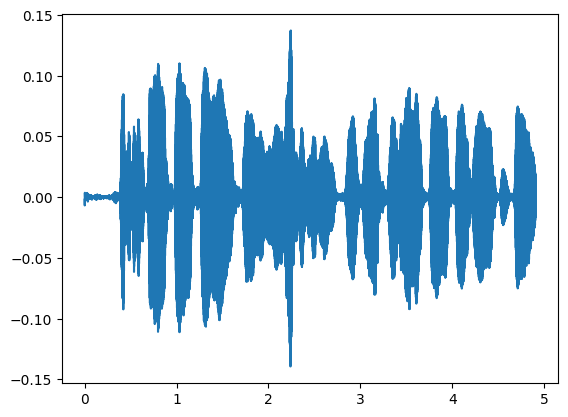

In [152]:
plt.plot(time,hi)

In [184]:
# Synths and effects


n_frames = 1000
hop_size - 64
n_samps = n_frames * hop_size

amps = np.linspace(1.0, -3.0, n_frames) # will go down over time
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic dist.
n_harmonics = 20
harmonic_dist = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
print(harmonic_dist.shape)
harmonic_dist = harmonic_dist[np.newaxis, :, :]
print(harmonic_dist.shape)
f0_hz = 440.0 * np.ones([1, n_frames, 1])
print(f"*****: {f_0_hz.shape}")
# f0_hz = 440.0 * np.linspace(0.0, 2.0, n_frames)
# print(f"*****: {f_0_hz.shape}")
harmonic_synth = ddsp.synths.Harmonic(n_samples=n_samps,scale_fn=ddsp.core.exp_sigmoid, sample_rate=sample_rate)

audio = harmonic_synth(amps, harmonic_distribution, f0_hz)


ipd.Audio(array_of_floats, rate=sample_rate)

(1000, 20)
(1, 1000, 20)
*****: (1, 1000, 1)
(1, 64000) <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 64000)
hi


In [185]:
def aud_to_ndarr(audio):
    print(audio.shape, type(audio))

    print(audio.shape)
    if len(audio.shape) == 2:
        print("hi")
        array_of_floats = audio[0]

    normalizer = float(np.iinfo(np.int16).max)
    array_of_ints = np.array(np.asarray(array_of_floats) * normalizer)
    return array_of_ints

In [195]:
# Noise

n_frames = 500
n_frequencies = 1000
n_samples = 64000

magnitudes = [tf.sin(tf.linspace(0.0, w, n_frequencies)) for w in np.linspace(8.0, 80.0, n_frames)]
magnitudes = 0.5 * tf.stack(magnitudes) ** 4.0
magnitudes = magnitudes[tf.newaxis, :, :]
print("::",magnitudes.shape)

filtered_noise_synth = ddsp.synths.FilteredNoise(n_samples=n_samples, scale_fn=None)
audio = filtered_noise_synth(magnitudes)

out= aud_to_ndarr(audio)
ipd.Audio(out, rate= sample_rate)

:: (1, 500, 1000)
(1, 64000) <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 64000)
hi


In [208]:
# wave table

n_samples = 64000
n_wavetables = 2048
n_frames = 100

# amps (batch x n_frames x 1)
amps = tf.linspace(0.5, 1e-3, n_frames)[tf.newaxis, :, tf.newaxis]

f_0_hz = 110 * tf.linspace(1.5, 1, n_frames)[tf.newaxis, :, tf.newaxis]

# wavetables (batch x n_frames x n_wavetable)
wave_table_sin = tf.sin(tf.linspace(0.0, 2.0 * np.pi, n_wavetables))
wave_table_sin = wave_table_sin[tf.newaxis, tf.newaxis, :]
print(wave_table_sin.shape)


# square
wave_table_square = tf.cast(wave_table_sin > 0.0, tf.float32) * 2.0 - 1.0
print(wave_table_square.shape)

wavetables = tf.concat([wave_table_sin, wave_table_sin], axis=1)
wavetables = ddsp.core.resample(wavetables, n_frames)
wavetable_synth = ddsp.synths.Wavetable(n_samples=n_samples, sample_rate=sample_rate, scale_fn=None)
audio = wavetable_synth(amps,wavetables, f_0_hz)

out = aud_to_ndarr(audio)
ipd.Audio(out, rate=sample_rate)


(1, 1, 2048)
(1, 1, 2048)
(1, 64000) <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 64000)
hi


In [212]:
reverb = ddsp.effects.ExpDecayReverb(reverb_length=48000)
gain = [[-2.0]] # linear gain of impulse response
decay = [[-2.0]] # exp. decay coefficient
audio_w_effects = reverb(audio, gain, decay)

effects_out = aud_to_ndarr(audio_w_effects)

ipd.Audio(effects_out, rate=sample_rate)


(1, 64000) <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 64000)
hi


In [226]:
filtered_reverb = ddsp.effects.FilteredNoiseReverb(reverb_length=48000, scale_fn=None)


n_frames = 1000
n_frequencies = 100

frequencies = np.linspace(0, sample_rate / 2.0, n_frequencies)
center_frequency = 4000.0 * np.linspace(0, 1.0, n_frames)
width = 500.0
gauss = lambda x, mu: 2.0 * np.pi * width ** -2.0 * np.exp(- ((x - mu) / width)**2.0)

pop_pop = np.array([gauss(frequencies, cf) for cf in center_frequency])
pop_pop = pop_pop[np.newaxis, ...]
pop_pop /= pop_pop.sum(axis=-1, keepdims = True) * 5

audio_out = reverb(audio_w_effects, gain, decay)

ipd.Audio(audio_out, rate=sample_rate)

In [274]:
# fir filter

test, samp_rate = sf.read("./data/test_whistle.wav")
test = test[np.newaxis, :]
print("Wav shape",test.shape)
print("Wav len:",len(test))
fir_filter = ddsp.effects.FIRFilter(scale_fn=None)
n_seconds= test.shape[1] / samp_rate
print("NUM SECONDS: ", n_seconds)
frame_rate = 100
n_frames = int(n_seconds * frame_rate)
print("NUM FRAMES: ",n_frames)
n_samples = int(n_frames * samp_rate / frame_rate)
trimmed = test[:, :n_samples]
print("Trimmed Shape: ",trimmed.shape)

n_frequencies = 1000
freqs = np.linspace(0, samp_rate / 2.0, n_frequencies)

lfo_rate = 0.5
n_cycles = n_seconds * lfo_rate
center_frequency = 1000 + 500 * np.sin(np.linspace(0, 2.0 * np.pi * n_cycles, n_frames))
print(center_frequency.shape)
width = 500.0
gauss = lambda x, mu: 2.0 * np.pi * width ** -2.0 * np.exp(- ((x - mu) / width) ** 2.0)


magnitudes = np.array([gauss(freqs, cf) for cf in center_frequency])
print(magnitudes.shape)
print("MAGNITUDES: ",magnitudes.shape)
magnitudes = magnitudes[np.newaxis, ...]
print("RESHAPED MAGNITUDES: ",magnitudes.shape)
magnitudes /= magnitudes.max(axis=-1, keepdims = True)


audio_out_filtered = fir_filter(trimmed, magnitudes)
ipd.Audio(audio_out_filtered, rate=samp_rate)

Wav shape (1, 235456)
Wav len: 1
NUM SECONDS:  4.905333333333333
NUM FRAMES:  490
Trimmed Shape:  (1, 235200)
(490,)
(490, 1000)
MAGNITUDES:  (490, 1000)
RESHAPED MAGNITUDES:  (1, 490, 1000)


In [292]:
def sin_phase(mod_rate):
  """Helper function."""
  n_samples = audio.shape[1]
  n_seconds = n_samples / sample_rate
  phase = tf.sin(tf.linspace(0.0, mod_rate * n_seconds * 2.0 * np.pi, n_samples))
  return phase[tf.newaxis, :, tf.newaxis]

def modulate_audio(audio, center_ms, depth_ms, mod_rate):
  mod_delay = ddsp.effects.ModDelay(center_ms=center_ms,
                                    depth_ms=depth_ms,
                                    gain_scale_fn=None,
                                    phase_scale_fn=None)

  phase = sin_phase(mod_rate)  # Hz
  gain = 1.0 * np.ones_like(audio)[..., np.newaxis]
  audio_out = 0.5 * mod_delay(audio, gain, phase)

  return ipd.Audio(audio_out,rate=samp_rate)


modulate_audio(test[:, :64000].astype(np.float32), center_ms=25.0, depth_ms=12.5, mod_rate=5.0)